In [2]:
"""
Our first version of our automated pipeline that is sequential only and uses our own evolutionary algorithm
"""


import os
import random
import numpy as np
import pandas as pd
from loader.load_dataset import load_dataset
from loader.Preprocessor import Preprocessor
from optimizer.SeqEvo.SeqEvo import SeqEvo
import utils.settings as settings
from utils.array_operations import split_list_by_percentage
from tensorflow import keras

from utils.folder_operations import new_saved_experiment_folder
from evaluation.conf_matrix import create_conf_matrix
from evaluation.text_metrics import create_text_metrics
from evaluation.metrics import accuracy, f1_score
from utils.Windowizer import Windowizer
from sklearn.model_selection import KFold
from utils.Converter import Converter
from optimizer.NeatNAS.NeatNAS import NeatNAS
from model_representation.ParametrizedLayer.PDenseLayer import PDenseLayer
from model_representation.EvoParam.IntEvoParam import IntEvoParam
from model_representation.ParametrizedLayer.PConv1DLayer import PConv1DLayer
from optimizer.SeqEvo.Selector import Selector
from optimizer.SeqEvo.Crosser import Crosser
from datetime import datetime
from model_representation.ParametrizedLayer.ParametrizedLayer import ParametrizedLayer
from model_representation.ParametrizedLayer.PLstmLayer import PLstmLayer
from utils.progress_bar import print_progress_bar

# Experiment Name ---------------------------------------------------------------
experiment_name = "best-performer-conv-finally"
currentDT = datetime.now()
currentDT_str = currentDT.strftime("%y-%m-%d_%H-%M-%S_%f")
experiment_name = experiment_name + "-" + currentDT_str

# Config --------------------------------------------------------------------------
window_size = 30*3
n_features = 51
n_classes = 6

layer_pool: 'list[ParametrizedLayer]' = [PDenseLayer, PConv1DLayer, PLstmLayer]
settings.init(_layer_pool=layer_pool)


# Lib -----------------------------------------------------------
leave_recording_out_split = lambda test_percentage: lambda recordings: split_list_by_percentage(list_to_split=recordings, percentage_to_split=test_percentage)
# leave_recording_out_split(test_percentage=0.3)(recordings)
def leave_person_out_split_idx(recordings, test_person_idx):
    subset_from_condition = lambda condition, recordings: [recording for recording in recordings if condition(recording)] 
    recordings_train = subset_from_condition(lambda recording: recording.subject != test_person_idx, recordings)
    recordings_test = subset_from_condition(lambda recording: recording.subject == test_person_idx, recordings)
    return recordings_train, recordings_test
leave_person_out_split = lambda test_person_idx: lambda recordings: leave_person_out_split_idx(recordings=recordings, test_person_idx=test_person_idx)
# leave_person_out_split(test_person_idx=2)(recordings) # 1-4, TODO: could be random


# Funcs --------------------------------------------------------------------------------------------------------------

load_recordings = lambda: load_dataset('data.csv', 
    label_column_name='ACTIVITY_IDX', 
    recording_idx_name='RECORDING_IDX', 
    column_names_to_ignore=['SUBJECT_IDX', 'MILLISECONDS']
)
 # os.path.join(settings.opportunity_dataset_csv_path, 'data.csv')

preprocess = lambda recordings: Preprocessor().jens_preprocess(recordings)
windowize = lambda recordings: Windowizer(window_size=window_size).jens_windowize(recordings)
convert = lambda windows: Converter(n_classes=n_classes).sonar_convert(windows)
flatten = lambda tuple_list: [item for sublist in tuple_list for item in sublist]
test_train_split = lambda recordings: leave_recording_out_split(test_percentage=0.25)(recordings)

recordings = load_recordings()

random.seed(1678978086101)
random.shuffle(recordings)

# Preprocessing
recordings = preprocess(recordings)

# Test Train Splits ----------------------------------------------------------------------------------------------------
test_percentage = 0.3
recordings_train, recordings_test = test_train_split(recordings)

# Validation Splits
k = 2
k_fold = KFold(n_splits=k, random_state=None)
recordings_train = np.array(recordings_train)
recordings_validation_splits = [(recordings_train[train_idx], recordings_train[val_idx]) for train_idx, val_idx in k_fold.split(recordings_train)]
# Output: [(recordings_train_01, recordings_test_01), (recordings_train_02, recordings_test_02), ...]
windows_validation_splits = list(map(lambda validation_split: map(windowize, validation_split), recordings_validation_splits))
# Output: [(windows_train_01, windows_test_01), (windows_train_02, windows_test_02), ...]
X_y_validation_splits = list(map(lambda validation_split: tuple(flatten(map(convert, validation_split))), windows_validation_splits))
# Output: [(X_train_01, y_train_01, X_val_01, y_val_01), (X_train_02, y_train_02, X_val_02, y_val_02), ...]


# Windowize, Convert --------------------------------------------------------------------------------------------------
windows_train, windows_test = windowize(recordings_train), windowize(recordings_test)
X_train, y_train, X_test, y_test = tuple(flatten(map(convert, [windows_train, windows_test])))

Will read dataset from data.csv
Filled 13959 NA values in column IMU-BACK-accX
Filled 13959 NA values in column IMU-BACK-accY
Filled 13959 NA values in column IMU-BACK-accZ
Filled 13959 NA values in column IMU-BACK-Quaternion1
Filled 13959 NA values in column IMU-BACK-Quaternion2
Filled 13959 NA values in column IMU-BACK-Quaternion3
Filled 13959 NA values in column IMU-BACK-Quaternion4
Filled 13959 NA values in column IMU-RLA-accX
Filled 13959 NA values in column IMU-RLA-accY
Filled 13959 NA values in column IMU-RLA-accZ
Filled 13959 NA values in column IMU-RLA-Quaternion1
Filled 13959 NA values in column IMU-RLA-Quaternion2
Filled 13959 NA values in column IMU-RLA-Quaternion3
Filled 13959 NA values in column IMU-RLA-Quaternion4
Filled 13959 NA values in column IMU-LLA-accX
Filled 13959 NA values in column IMU-LLA-accY
Filled 13959 NA values in column IMU-LLA-accZ
Filled 13959 NA values in column IMU-LLA-Quaternion1
Filled 13959 NA values in column IMU-LLA-Quaternion2
Filled 13959 NA v

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 90, 51)]          0         
_________________________________________________________________
reshape (Reshape)            (None, 90, 51, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 9, 17, 32)         192       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 6, 64)          10304     
_________________________________________________________________
flatten (Flatten)            (None, 384)               0         
_________________________________________________________________
dense (Dense)                (None, 6)                 2310      
Total params: 12,806
Trainable params: 

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: valentindoering (use `wandb login --relogin` to force relogin)
/Users/valentin/opt/anaconda3/envs/mycondaenv/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


Epoch 1/5
253/253 [==============================] - 1s 3ms/step - loss: 11.7309 - accuracy: 0.3591 - val_loss: 4.7003 - val_accuracy: 0.3449
Epoch 2/5
253/253 [==============================] - 1s 3ms/step - loss: 2.5849 - accuracy: 0.4205 - val_loss: 2.3354 - val_accuracy: 0.3657
Epoch 3/5
253/253 [==============================] - 1s 2ms/step - loss: 1.6146 - accuracy: 0.4560 - val_loss: 1.7988 - val_accuracy: 0.4211
Epoch 4/5
253/253 [==============================] - 1s 2ms/step - loss: 1.3942 - accuracy: 0.4765 - val_loss: 1.6860 - val_accuracy: 0.3741
Epoch 5/5
253/253 [==============================] - 1s 3ms/step - loss: 1.3161 - accuracy: 0.4947 - val_loss: 1.6334 - val_accuracy: 0.4260


/Users/valentin/opt/anaconda3/envs/mycondaenv/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


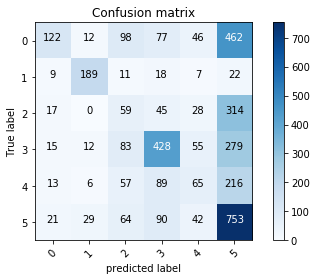

In [3]:
%load_ext autoreload
%autoreload 2

from models.JensModel import JensModel
from models.MultilaneConv import MultilaneConv
from models.BestPerformerConv import BestPerformerConv
from models.OldLSTM import OldLSTM
from models.MultilaneConvLSTM import MultilaneConvLSTM
from models.KirillAlexDeepConvLSTM import KirillAlexDeepConvLSTM
from models.AlternativeDeepConvLSTM import AlternativeDeepConvLSTM
from models.SenselessDeepConvLSTM import SenselessDeepConvLSTM
from models.ConvExperimental import ConvExperimental

experiment_name = "conv-eeexxxppp"

currentDT = datetime.now()
currentDT_str = currentDT.strftime("%y-%m-%d_%H-%M-%S_%f")
experiment_name = experiment_name + "-" + currentDT_str

# or JensModel
model = ConvExperimental(
    window_size=window_size, 
    n_features=recordings[0].sensor_frame.shape[1], 
    n_outputs=n_classes, 
    n_epochs=5, 
    learning_rate=0.001, 
    batch_size=32, 
    wandb_config={
        'project': 'all_experiments_project',
        'entity': 'valentindoering',
        'name': experiment_name
    }
)
# learning_rate=0.001
# wandb_project=experiment_name
model.fit(X_train, y_train)

y_test_pred = model.predict(X_test)

# Create Folder, save model export and evaluations there
experiment_folder_path = new_saved_experiment_folder(experiment_name) # create folder to store results

# model.export(experiment_folder_path) # opt: export model to folder
create_conf_matrix(experiment_folder_path, y_test_pred, y_test)
create_text_metrics(experiment_folder_path, y_test_pred, y_test, [accuracy]) # TODO: at the moment only with one function working! data gets changed (passed by reference) - refactor metric functions